In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import eit
import pandas as pd
import matplotlib
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='cm')

In [2]:
root_path = '/Users/jon/Coding/old_hydrocyclone/notebooks/results/temporal_recovery_'
run_id = 'n=5_aab75251'
compare_id = 'n=5_collocation_cde5b514'

In [3]:
root_dir = root_path + run_id
with open(os.path.join(root_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f, encoding='latin1')
summary = pd.read_csv(os.path.join(root_dir, 'summary.csv'))
params_dict = {}
with open(os.path.join(root_dir, 'params.py')) as f:
    exec(f.read(), {}, params_dict)

temps = params_dict['intermediate_temperatures']
indices = np.arange(temps, len(results), temps+1, dtype=np.int)

names = summary.iloc[indices].Kernel_Name
print(names)
frames = [results[i] for i in indices]
weights = [pd.read_csv(os.path.join(root_dir, 'detailed_summaries', n + '.csv')).Weights for n in names]
to_plot = [np.average(np.exp(f), weights=w, axis=0) for f, w in zip(frames, weights)]

99     Frame_11
199    Frame_12
299    Frame_13
399    Frame_14
499    Frame_15
599    Frame_16
699    Frame_17
799    Frame_18
Name: Kernel_Name, dtype: object


In [4]:
max_level = np.max([np.max(m) for m in to_plot])
min_level = np.min([np.min(m) for m in to_plot])
levels = np.linspace(min_level, max_level, 20)

In [5]:
proposal_design = eit.grids.construct_shell(np.linspace(0,1,params_dict['n_radii_inverse']))

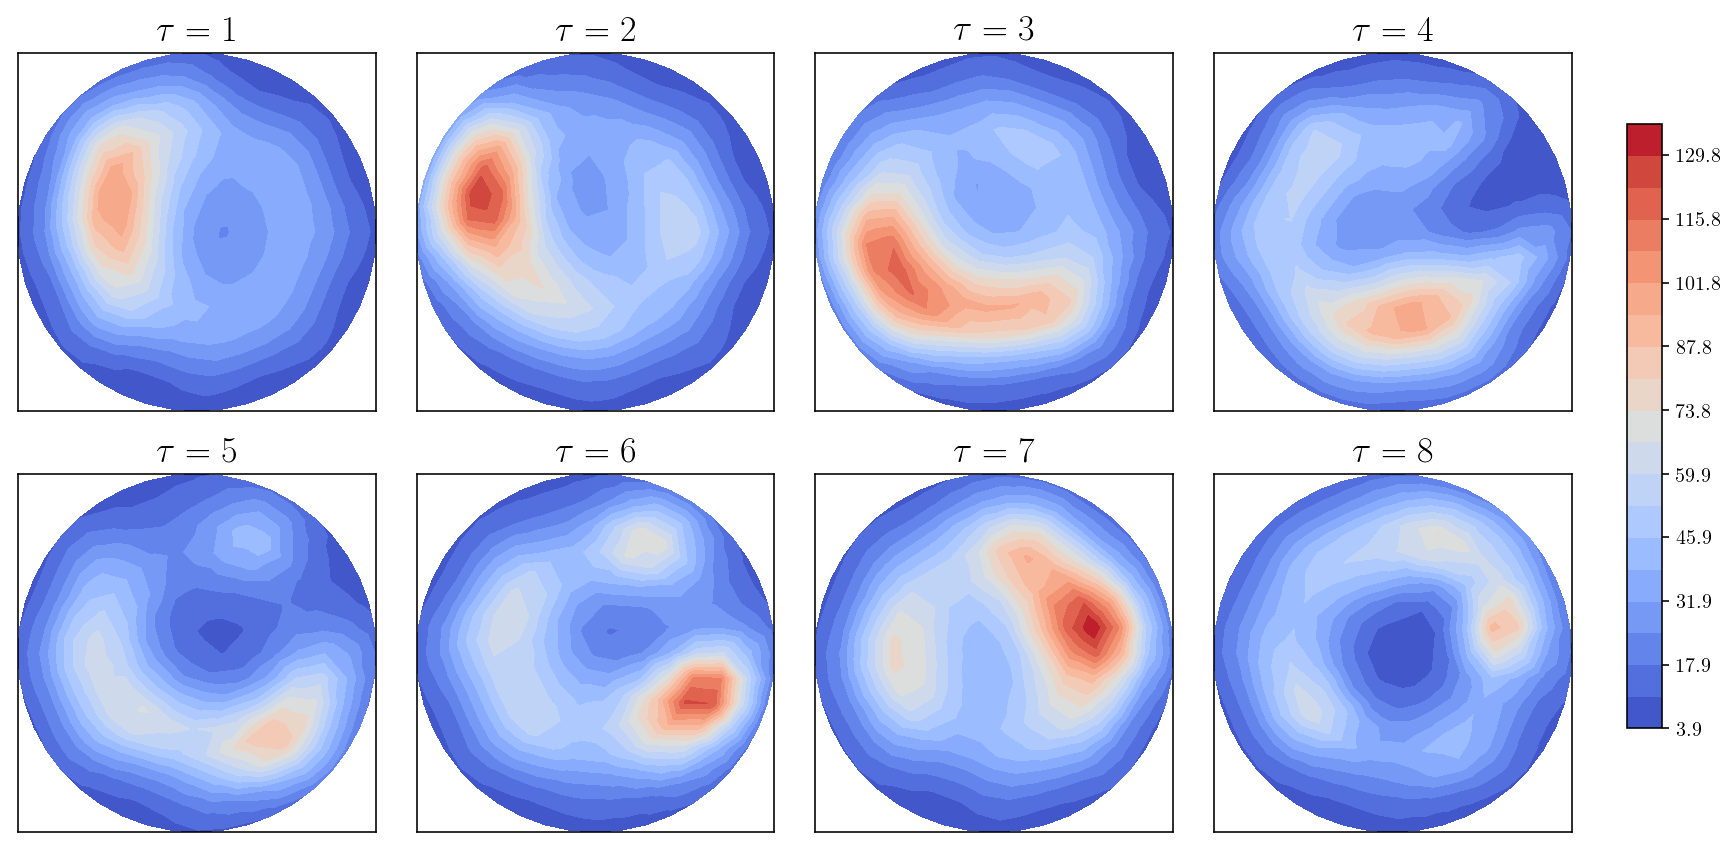

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(12,6))
raveled = [a for a1 in axes for a in a1]
frame_ixs = np.arange(1, 1+len(to_plot))

for mean, axis, frame in zip(to_plot, raveled, frame_ixs):
    im = axis.tricontourf(proposal_design[:,0], proposal_design[:,1], mean, levels, cmap='coolwarm')
    axis.set_aspect('equal')
    axis.set_title(r'$\tau={}$'.format(frame), fontsize=18)
    axis.set_xticks([])
    axis.set_yticks([])
    
fig.tight_layout()
fig.subplots_adjust(right=0.92)
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax)
plt.savefig('figures/temporal_recovery_means.pdf'.format(run_id), bbox_inches='tight', transparent=True, )

In [7]:
with open(os.path.join(root_path + compare_id, 'results.pkl'), 'rb') as f:
    compare_results = pickle.load(f, encoding='latin1')

compare_frames = [compare_results[i] for i in indices]

In [8]:
variances = [np.mean(np.std(np.exp(f), axis=0)) for f in frames]
compare_variances = [np.mean(np.std(np.exp(f), axis=0)) for f in compare_frames]

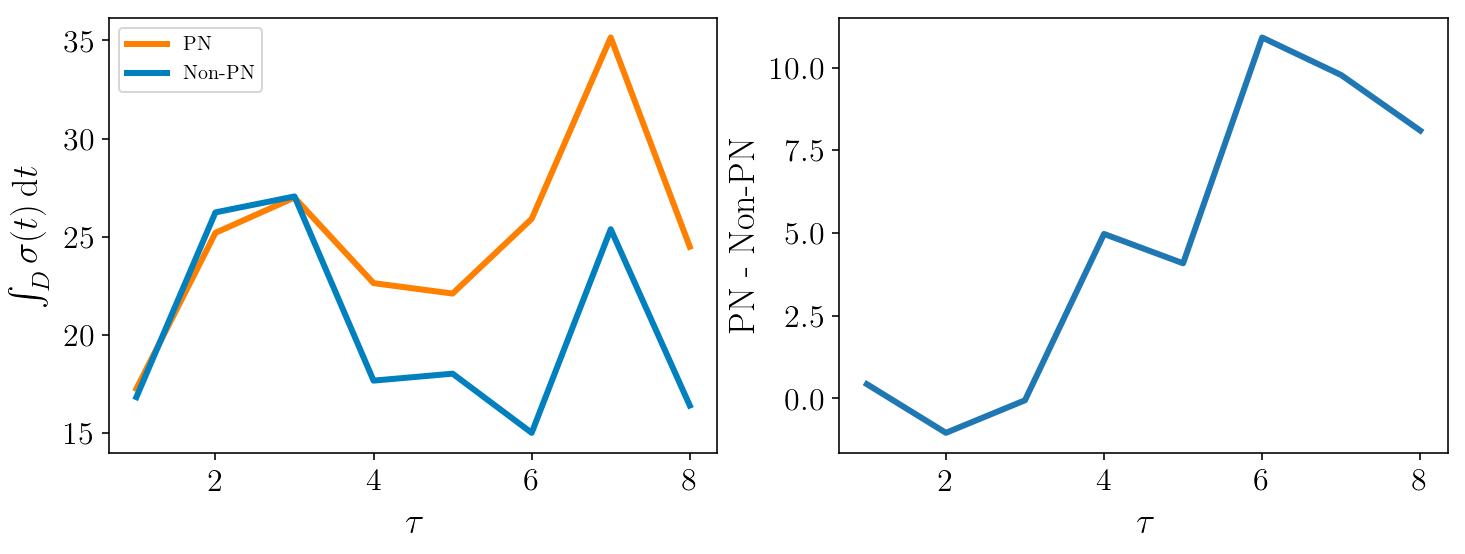

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(frame_ixs, variances, label='PN', c=plt.cm.get_cmap('autumn')(0.5), linewidth=3)
plt.plot(frame_ixs, compare_variances, label='Non-PN', c=plt.cm.get_cmap('winter')(0.5), linewidth=3)
plt.xlabel(r'$\tau$', fontsize=18)
plt.ylabel(r'$\int_D \sigma(t) \:\textrm{d}t$', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend()
plt.subplot(122)
plt.plot(frame_ixs, np.array(variances) - np.array(compare_variances), linewidth=3)
plt.tick_params(labelsize=16)
plt.xlabel(r'$\tau$', fontsize=18)
plt.ylabel(r'PN - Non-PN', fontsize=18)
plt.savefig('figures/temporal_recovery_variance_{}.pdf'.format(run_id), bbox_inches='tight', transparent=True)